In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as mse, precision_score as precision, accuracy_score as accuracy, recall_score as recall

In [261]:
df = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [263]:
df.drop(['url',' timedelta'], axis=1, inplace=True)

In [264]:
df[df[' shares'] > 100000]

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
3043,11.0,506.0,0.565844,1.0,0.672956,28.0,6.0,1.0,0.0,4.764822,...,0.050000,1.000000,-0.422500,-1.000000,-0.125000,0.600000,-0.400000,0.100000,0.400000,227300
3139,9.0,502.0,0.547094,1.0,0.719870,10.0,1.0,1.0,0.0,4.858566,...,0.050000,0.800000,-0.189899,-0.600000,-0.100000,1.000000,0.850000,0.500000,0.850000,144400
3145,11.0,382.0,0.487805,1.0,0.605809,15.0,3.0,11.0,1.0,4.777487,...,0.033333,0.700000,-0.277778,-0.433333,-0.200000,0.000000,0.000000,0.500000,0.000000,617900
4506,10.0,905.0,0.460067,1.0,0.645161,3.0,2.0,21.0,0.0,4.492818,...,0.033333,1.000000,-0.224913,-0.666667,-0.125000,0.000000,0.000000,0.500000,0.000000,306100
5370,11.0,893.0,0.517202,1.0,0.716730,17.0,11.0,0.0,11.0,4.586786,...,0.033333,1.000000,-0.348674,-1.000000,-0.100000,0.000000,0.000000,0.500000,0.000000,690400
5554,8.0,954.0,0.510917,1.0,0.696491,25.0,21.0,0.0,11.0,4.611111,...,0.100000,1.000000,-0.255655,-0.700000,-0.033333,0.000000,0.000000,0.500000,0.000000,112500
8037,7.0,316.0,0.607973,1.0,0.730159,26.0,2.0,0.0,0.0,4.547468,...,0.100000,1.000000,-0.366204,-0.666667,-0.150000,1.000000,0.550000,0.500000,0.550000,118700
9365,12.0,688.0,0.500734,1.0,0.643357,28.0,3.0,15.0,1.0,4.893895,...,0.050000,1.000000,-0.217593,-0.400000,-0.050000,0.100000,-0.300000,0.400000,0.300000,843300
9448,9.0,1015.0,0.399198,1.0,0.545310,34.0,4.0,13.0,2.0,4.820690,...,0.033333,1.000000,-0.295238,-1.000000,-0.125000,0.000000,0.000000,0.500000,0.000000,104100
9575,9.0,1118.0,0.475320,1.0,0.714968,4.0,2.0,1.0,15.0,4.757603,...,0.033333,1.000000,-0.279167,-0.500000,-0.100000,0.000000,0.000000,0.500000,0.000000,196700


In [265]:
#dropping the six outliers that are beyond 400,000 shares 
to_drop = df[df[' shares'] > 100000].index 
df.drop(labels=to_drop, axis=0, inplace = True)




In [268]:
df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,...,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000
mean,10.397994,546.517254,0.548278,0.996615,0.689271,10.878619,3.294271,4.541757,1.248446,4.548718,...,0.095461,0.756760,-0.259474,-0.521874,-0.107452,0.282267,0.071432,0.341809,0.155989,3100.751579
std,2.113984,470.721844,3.523278,5.235048,3.267194,11.327396,3.855810,8.308267,4.108235,0.843073,...,0.071326,0.247678,0.127641,0.290188,0.095269,0.324161,0.265346,0.188803,0.226225,5991.066519
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,0.470864,1.000000,0.625767,4.000000,1.000000,1.000000,0.000000,4.478452,...,0.050000,0.600000,-0.328282,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,945.000000
50%,10.000000,409.500000,0.539216,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664112,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,12.000000,716.000000,0.608584,1.000000,0.754627,14.000000,4.000000,4.000000,1.000000,4.854873,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.148504,0.500000,0.250000,2800.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,98700.000000


(0.0, 30000.0)

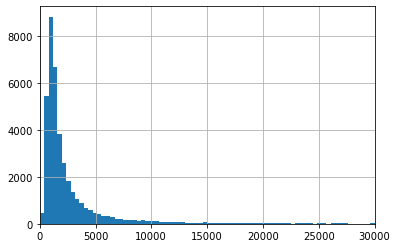

In [269]:
fig, ax = plt.subplots()
df[' shares'].hist(ax = ax, bins = 250)
ax.set_xlim(0, 30000)

In [270]:
baseline = np.array([1] * len(df[' shares'])) * df[' shares'].mean()
rmse_base = (mse(baseline, df[' shares']))**.5
base_residuals = abs(baseline - df[' shares'])
rmse_base

5990.990847429362

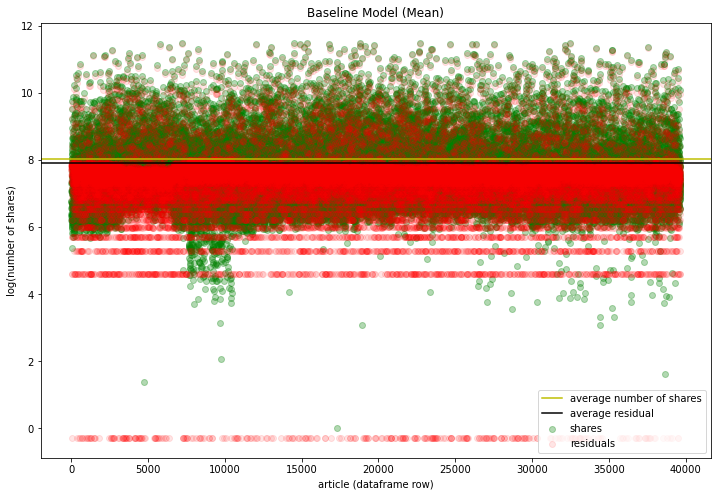

In [248]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(df.index, np.log(df[' shares']), alpha = .3, c = 'g', label = 'shares')
ax.axhline(np.log(df[' shares'].mean()), label = 'average number of shares', c = 'y')
ax.set_ylabel('log(number of shares)')
ax.set_title('Baseline Model (Mean)')
ax.set_xlabel('article (dataframe row)')
ax.scatter(df.index, np.log(abs(baseline - df[' shares'])), c = 'r', alpha = .1, label = 'residuals')
ax.axhline(np.log(np.mean(base_residuals)), label = 'average residual', c = 'black')
ax.legend()
plt.savefig('../img/Baseline-Model.png');

### Using the mean as the baseline, want to begin with fitting a simple linear regression model 


In [271]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train)

In [273]:
first = LinearRegression().fit(X_subtrain, y_subtrain)
firsthat = first.predict(X_subtest)
mse(firsthat, y_subtest) ** .5

5941.5825434187145

#### The rmse of the linear model is slightly better than the baseline. How to move forward?
- featurization
- gradient boosting regressor  / Grid Search?
- random forest regressor?


In [274]:
#lets see how random forest performs 
forest1 = RandomForestRegressor()
forest1.fit(X_subtrain, y_subtrain)
foresthat = forest1.predict(X_subtest)
mse(y_subtest, foresthat) ** .5

6131.519223227163

In [80]:
def model_test(model, X_tn, X_tst, y_tn, y_tst):
    model = model.fit(X_tn, y_tn)
    yhat = model.predict(X_tst)
    return mse(y_tst, yhat) ** .5

In [81]:
model_test(RandomForestRegressor(), X_subtrain, X_subtest, y_subtrain, y_subtest)

8187.48405777745

#### The Random Forest (out of the box) is performing as terribly as the first model, including the pattern of outliers
-should i try to gridsearch for random forest? 


In [275]:
grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = grid,
                            cv =5)
rf_gridsearch.fit(X_subtrain, y_subtrain)
rf_gridsearch.best_params_

{'max_depth': 4, 'max_features': 0.5, 'n_estimators': 75}

In [276]:
model_test(RandomForestRegressor(n_estimators = 75, max_depth=4, max_features=.5), X_subtrain, X_subtest, y_subtrain, y_subtest)

5937.191009222674

In [277]:
rf = RandomForestRegressor(n_estimators=75,
                          max_depth = 4,
                          max_features=.5).fit(X_train, y_train)
rf_hat = rf.predict(X_test)
rf_rmse = mse(y_test, rf_hat) ** .5
rf_rmse


5655.804957266807

#### With hyperparameters from gridsearching for random forest, got a slightly better score than with the baseline / out-of-box random forest, but it is not even better than the linear regression

In [278]:
#next, trying gradient boosting regressor 
model_test(GradientBoostingRegressor(), X_subtrain, X_subtest, y_subtrain, y_subtest)

5980.433957956011

In [279]:
#gridsearch for gradient boosting 
gb_grid = {'learning_rate':[.1],
          'max_depth': [1, 3, 5],
          'min_samples_leaf' : [2, 4],
          'max_features':[10, 30],
          'n_estimators':[50,75, 100]}

gb_gridsearch = GridSearchCV(estimator=GradientBoostingRegressor(),
                            param_grid = gb_grid,
                            cv = 10)
gb_gridsearch.fit(X_subtrain, y_subtrain)
gb_gridsearch.best_params_

KeyboardInterrupt: 

In [284]:
model_test(GradientBoostingRegressor(learning_rate=.1, max_depth=3, max_features = .1,
                                    min_samples_leaf=3, n_estimators = 100), X_subtrain, X_subtest, y_subtrain, y_subtest)

5911.960465273492

In [285]:
gbr = GradientBoostingRegressor(learning_rate = .1,
                               max_depth = 3, 
                               max_features = .1,
                               min_samples_leaf=3, 
                               n_estimators = 100)

In [286]:
gbr.fit(X_subtrain, y_subtrain)

GradientBoostingRegressor(max_features=0.1, min_samples_leaf=3)

In [287]:
gbrhat = gbr.predict(X_subtest)
mse(y_subtest, gbrhat) ** .5

5924.781793947423

In [288]:
gbrhat2 = gbr.predict(X_train)
gbr_rmse = mse(y_train, gbrhat2) ** .5
gbr_rmse

5718.545228435142

In [289]:
gbrhat3 = gbr.predict(X_test)
final_gbr_rmse = mse(y_test, gbrhat3) ** .5
final_gbr_rmse

5648.600514834264

In [290]:
feature_importances_sorted

Index([' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
       ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs',
       ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' gl

In [129]:
gbr.feature_importances_

array([0.00500355, 0.05864166, 0.01121388, 0.        , 0.02802779,
       0.01576268, 0.0037401 , 0.0139307 , 0.00450316, 0.0192264 ,
       0.00032751, 0.        , 0.00252038, 0.00436037, 0.        ,
       0.        , 0.        , 0.0012558 , 0.0371049 , 0.06018928,
       0.00648537, 0.00258584, 0.01443987, 0.0447043 , 0.07197784,
       0.16493935, 0.06666917, 0.03795244, 0.05865749, 0.        ,
       0.        , 0.00099479, 0.        , 0.        , 0.        ,
       0.        , 0.00145978, 0.0305927 , 0.01975373, 0.03088235,
       0.04494775, 0.01682018, 0.00899775, 0.0020931 , 0.        ,
       0.00206839, 0.0013626 , 0.00422283, 0.00615235, 0.00064494,
       0.        , 0.02710922, 0.0119223 , 0.0209282 , 0.00828873,
       0.01285873, 0.01269204, 0.00098773])

In [153]:
feat_imp_idx = gbr.feature_importances_.argsort()
srted_idx = feat_imp_idx
srted_feats = X.columns[srted_idx]

In [154]:
srtd_feat_imps = np.sort(gbr.feature_importances_)

Text(0.5, 1.0, 'Feature Importances through Gradient Boosting')

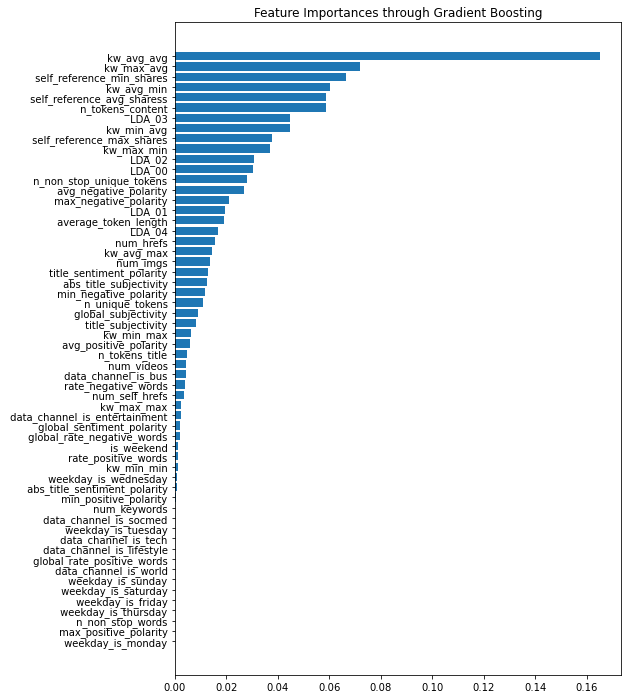

In [159]:
fig, ax = plt.subplots(figsize=(8,12))
ax.barh(srted_feats, srtd_feat_imps)
ax.set_title('Feature Importances through Gradient Boosting')


In [176]:
top_25 = srted_feats[::-1][:25]

In [292]:
#what happens if i refit the model with only the top 25 features according to feature importances? 
new_X = df.loc[:,top_25]
newX_train, newX_test, newy_train, newy_test = train_test_split(new_X, y)

In [182]:
rf_grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

new_rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = rf_grid,
                            cv =5, verbose =1)
new_rf_gridsearch.fit(newX_train, newy_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': ['auto', 0.5],
                         'n_estimators': [50, 75, 100]},
             verbose=1)

In [183]:
new_rf_gridsearch.best_params_

{'max_depth': 4, 'max_features': 0.5, 'n_estimators': 75}

In [293]:
new_rf = RandomForestRegressor(n_estimators=75,
                              max_depth = 4,
                              max_features = .5).fit(newX_train, newy_train)
new_rf_hat = new_rf.predict(newX_test)
new_rf_rmse = mse(newy_test, new_rf_hat) ** .5
new_rf_rmse

5853.930721539655

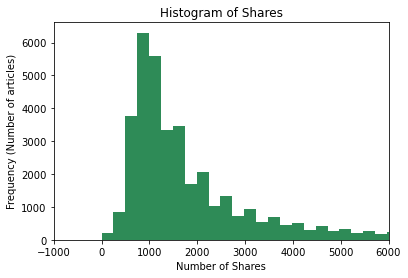

In [222]:
fig, ax = plt.subplots()
ax.hist(df[' shares'], bins = 1250, color = 'seagreen')
ax.set_xlim(-1000, 6000)
ax.set_title('Histogram of Shares')
ax.set_ylabel('Frequency (Number of articles)')
ax.set_xlabel('Number of Shares')
plt.savefig('../img/histogram-shares.png')

#### All of the data does not belong to the same distribution its why my models are so bad. Need to build a classifier model to label articles which have more or less than 3000 shares. Then I can build regression model within those classes. 


In [295]:
df['class'] = df[' shares'] >= 3000

In [296]:
df['class'] = df['class'].apply(lambda x : 0 if x == False else 1)

In [338]:
class_X = df.iloc[:, :-1]
class_y = df.iloc[:, -1]
class_X_train, class_X_test, class_y_train, class_y_test = train_test_split(class_X, class_y)


In [339]:
class_model = LogisticRegression().fit(class_X_train, class_y_train)
class_hat = class_model.predict(class_X_test)
print(f' Precision: {precision(class_y_test, class_hat)} \n \
Accuracy : {accuracy(class_y_test, class_hat)} \n \
Recall: {recall(class_y_test, class_hat)}')

 Precision: 0.8303647158608991 
 Accuracy : 0.9356370617358796 
 Recall: 0.8920273348519362


/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [346]:
X0 = df[df['class'] == 0].iloc[:, :-2]
y0 = df[df['class']==0].iloc[:, -2]
X1 = df[df['class']==1].iloc[:, :-2]
y1 = df[df['class']==1].iloc[:, -2]

In [352]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0)
X0_subtrain, X0_subtest, y0_subtrain, y0_subtest = train_test_split(X0_train, y0_train)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X1_subtrain, X1_subtest, y1_subtrain, y1_subtest = train_test_split(X1_train, y1_train)

In [349]:
rf_grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

new_rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = rf_grid,
                            cv =5, verbose =2)
new_rf_gridsearch.fit(X0_subtrain, y0_subtrain)
new_rf_gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....max_depth=2, max_features=auto, n_estimators=50; total time=   3.1s
[CV] END ....max_depth=2, max_features=auto, n_estimators=50; total time=   3.0s
[CV] END ....max_depth=2, max_features=auto, n_estimators=50; total time=   3.0s
[CV] END ....max_depth=2, max_features=auto, n_estimators=50; total time=   3.1s
[CV] END ....max_depth=2, max_features=auto, n_estimators=50; total time=   3.1s
[CV] END ....max_depth=2, max_features=auto, n_estimators=75; total time=   4.8s
[CV] END ....max_depth=2, max_features=auto, n_estimators=75; total time=   4.7s
[CV] END ....max_depth=2, max_features=auto, n_estimators=75; total time=   4.7s
[CV] END ....max_depth=2, max_features=auto, n_estimators=75; total time=   4.7s
[CV] END ....max_depth=2, max_features=auto, n_estimators=75; total time=   4.5s
[CV] END ...max_depth=2, max_features=auto, n_estimators=100; total time=   6.1s
[CV] END ...max_depth=2, max_features=auto, n_es

{'max_depth': 6, 'max_features': 0.5, 'n_estimators': 100}

In [354]:
rf0 = RandomForestRegressor(n_estimators=100,
                           max_features=.5,
                           max_depth=6).fit(X0_train, y0_train)
rf0_hat = rf0.predict(X0_test)
rf0_rmse = mse(y0_test, rf0_hat) ** .5

In [355]:
rf_grid = {'n_estimators':[50, 75, 100], 
       'max_depth' : [2, 4, 6],
       'max_features' : ['auto', .5]}

new_rf_gridsearch = GridSearchCV(estimator = RandomForestRegressor(),
                            param_grid = rf_grid,
                            cv =5, verbose =1)
new_rf_gridsearch.fit(X1_subtrain, y1_subtrain)
new_rf_gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'max_depth': 4, 'max_features': 0.5, 'n_estimators': 50}

In [357]:
rf1 = RandomForestRegressor(n_estimators=50,
                           max_features=.5,
                           max_depth=4).fit(X1_train, y1_train)
rf1_hat = rf1.predict(X1_test)
rf1_rmse = mse(y1_test, rf1_hat) ** .5
rf1_rmse

10836.388803310207

#### I think I might have to split the classes at 10,000 shares 


<AxesSubplot:>

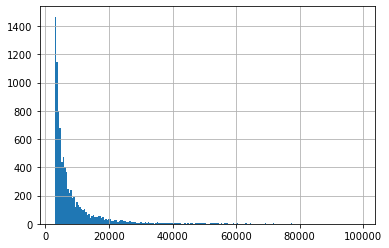

In [363]:
df[df['class']==1][' shares'].hist(bins=200)

In [364]:
len(df[df[' shares'] > 20000])

760

In [368]:
df[df[' shares'] > 10000]

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,class
16,8.0,1118.0,0.512397,1.0,0.709770,26.0,18.0,12.0,1.0,4.703936,...,1.000,-0.401437,-1.000,-0.050000,0.566667,-0.100000,0.066667,0.100000,13600,1
19,8.0,1207.0,0.410579,1.0,0.548969,24.0,24.0,42.0,0.0,4.716653,...,1.000,-0.226786,-0.500,-0.050000,0.500000,0.000000,0.000000,0.000000,17100,1
129,10.0,254.0,0.627530,1.0,0.697143,5.0,1.0,0.0,3.0,4.625984,...,1.000,-0.283333,-0.400,-0.166667,0.600000,0.500000,0.100000,0.500000,19400,1
146,11.0,459.0,0.563193,1.0,0.737226,10.0,0.0,1.0,0.0,4.810458,...,0.700,-0.234259,-0.600,-0.050000,0.000000,0.000000,0.500000,0.000000,10400,1
174,11.0,277.0,0.450185,1.0,0.494737,34.0,3.0,15.0,0.0,4.494585,...,0.375,-0.348333,-0.800,-0.166667,0.000000,0.000000,0.500000,0.000000,11500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39503,12.0,590.0,0.513465,1.0,0.658960,19.0,2.0,1.0,0.0,4.732203,...,1.000,-0.365000,-0.750,-0.050000,0.000000,0.000000,0.500000,0.000000,11700,1
39537,9.0,174.0,0.726190,1.0,0.886598,4.0,4.0,2.0,0.0,4.224138,...,1.000,-0.311111,-0.700,-0.100000,0.000000,0.000000,0.500000,0.000000,45000,1
39542,14.0,485.0,0.509595,1.0,0.662207,12.0,7.0,1.0,1.0,4.849485,...,0.800,-0.325000,-0.600,-0.100000,0.454545,0.136364,0.045455,0.136364,16800,1
39586,12.0,318.0,0.553398,1.0,0.678392,5.0,1.0,1.0,0.0,4.641509,...,0.500,-0.100000,-0.125,-0.050000,0.454545,0.136364,0.045455,0.136364,10200,1


In [367]:
2127/39000

0.054538461538461536